In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive/')
# Read in the file with image and label information.
all_xray_df1 = pd.read_csv("/content/drive/My Drive/Data/data/Data_Entry_2017.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Make Sure GPU is being used

In [5]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.advanced_activations import PReLU, LeakyReLU

from keras.applications.inception_v3 import InceptionV3, preprocess_input

import scipy
from scipy import misc

Using TensorFlow backend.


In [0]:
# Did this for flow from data
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
#pip uninstall keras-preprocessing
#pip install git+https://github.com/keras-team/keras-preprocessing.git

In [8]:
import glob
all_image_paths = {os.path.basename(x): x for x in 
                   glob.glob(os.path.join('/content/drive/My Drive/Data/data/combined_data', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df1.shape[0])

Scans found: 25657 , Total Headers 112120


In [9]:
# Add the path to the dataset.
all_xray_df1['path'] = all_xray_df1['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df1.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
67517,00016678_005.png,Atelectasis,5,16678,57,M,AP,2500,2048,0.168000,0.168000,NaN,None
110765,00030183_006.png,Pneumothorax,6,30183,49,F,PA,2021,2020,0.194311,0.194311,NaN,None
28444,00007420_007.png,No Finding,7,7420,24,M,PA,2992,2991,0.143000,0.143000,NaN,/content/drive/My Drive/Data/data/combined_dat...


In [10]:
# Keep only the records that has corresponding images
all_xray_df = all_xray_df1[~all_xray_df1['path'].isin([None])]
all_xray_df.shape

(25591, 13)

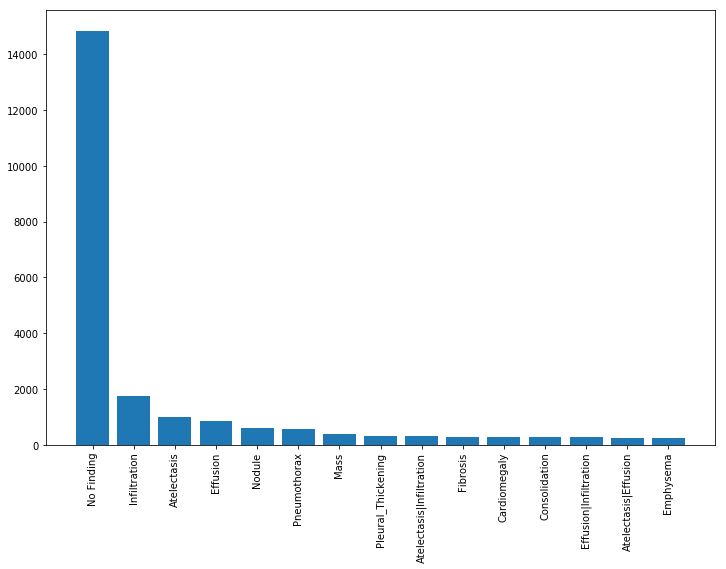

In [11]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [12]:
# Reducing no findings
first_half = all_xray_df[0:18000]
second_half = all_xray_df[18000:]

all_xray_trial1 = first_half[first_half['Finding Labels']!= 'No Finding']
all_xray_trial2 = second_half
frames = [all_xray_trial1, all_xray_trial2]
all_xray_df = pd.concat(frames)
len(all_xray_df)

15164

In [13]:
# We will remove No finding labels as there are more than 50% No finding cases that can make data imbalanced
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
30427,00007937_000.png,No Finding,0,7937,62,F,PA,2654,2991,0.143,0.143,NaN,/content/drive/My Drive/Data/data/combined_dat...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
33889,00008879_000.png,Nodule,0,8879,49,F,PA,2500,2048,0.168,0.168,NaN,/content/drive/My Drive/Data/data/combined_dat...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
33373,00008745_032.png,Edema|Infiltration,32,8745,46,M,AP,2500,2048,0.168,0.168,NaN,/content/drive/My Drive/Data/data/combined_dat...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (6) [('Atelectasis', 2485), ('Effusion', 2484), ('Infiltration', 3684), ('No Finding', 4414), ('Nodule', 1272), ('Pneumothorax', 1148)]


In [0]:
# Split the lables by '|' and check how many labels are present for each image.
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(len(sample_weights), weights=sample_weights)


In [16]:
len(sample_weights)

15164

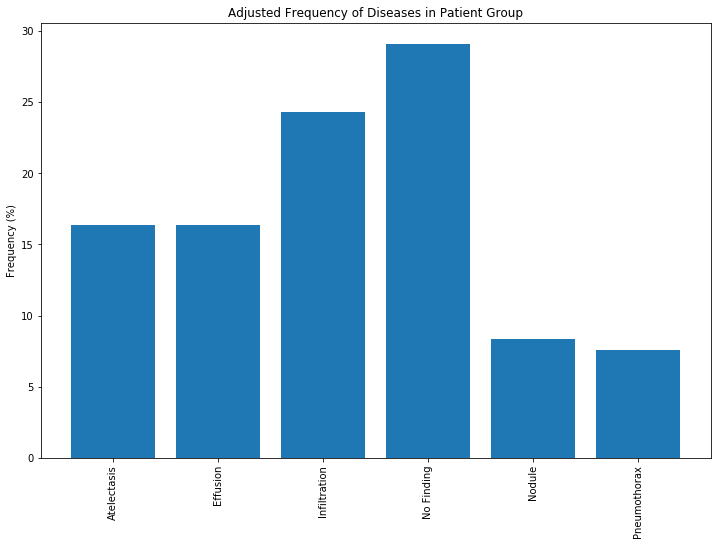

In [17]:
# Adjusted frequency of disease grps
label_counts = 100*np.mean(all_xray_df[all_labels].values,0) # mean number of labels for each image
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Data for Modeling

In [0]:
# Prepare training data
# Create target vector
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [19]:
# data split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2019,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 11373 test 3791


# Create Generator

In [0]:
# Loading and transforming images
# ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [0]:
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

## To make sure that the current GPU memory utilization is 0

In [22]:
# https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=418ae6ba2775d0823f71c3236ab6a9dcaf37da4c0cb4926704b0b2d3206249b1
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.6 GB  | Proc size: 575.3 MB
GPU RAM Free: 11370MB | Used: 71MB | Util   1% | Total 11441MB


In [24]:
IMG_SIZE = (255, 255)
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

train_gen = datagen.flow_from_dataframe(dataframe=train_df, directory=None, x_col = 'path',
y_col = 'newLabel', class_mode = 'categorical',
classes = all_labels, target_size = IMG_SIZE, batch_size = 32) 

test_gen = datagen.flow_from_dataframe(dataframe= test_df, directory=None, x_col = 'path',
y_col = 'newLabel', class_mode = 'categorical',
classes = all_labels, target_size = IMG_SIZE, batch_size = 512 ) # we can use much larger batches for evaluation

test_X, test_Y = next(datagen.flow_from_dataframe(dataframe=test_df, 
directory=None,
x_col = 'path', y_col = 'newLabel', 
class_mode = 'categorical', classes = all_labels,
target_size = IMG_SIZE,  batch_size = 1024))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Found 9711 validated image filenames belonging to 6 classes.
Found 3203 validated image filenames belonging to 6 classes.
Found 3203 validated image filenames belonging to 6 classes.


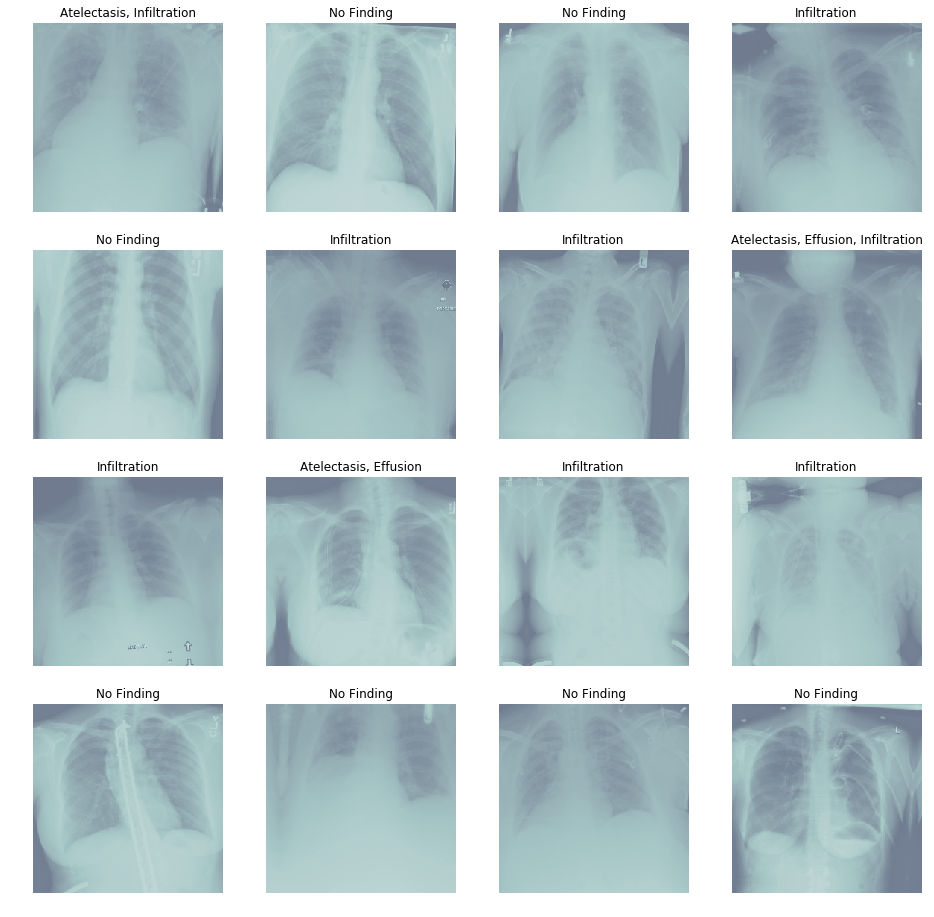

In [25]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [0]:
# Evaluation metrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
!pip install efficientnet
from efficientnet import EfficientNetB3

modelb3 = EfficientNetB3(weights='imagenet')

  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=14289 sha256=230516a748bc9127e3531234e809c5f7916d5abfd7e167dce7c5f22fe8e08fac
  Stored in directory: /root/.cache/pip/wheels/5c/34/68/a611a699a28239e964ccf144c0e767cdb5439fee82ec5de6e0
Successfully built efficientnet


W0814 15:43:22.670583 139723262928768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 15:43:22.673953 139723262928768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 15:43:22.689297 139723262928768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/efficientnet/initializers.py:44: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0814 15:43:22.732387 139723262928768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 15:43:22.733834 139723262928768 depre

50126848/50122568 [==============================] - 2s 0us/step


In [28]:
effnet_mdl = EfficientNetB3(input_shape=t_x.shape[1:], weights='imagenet', include_top=False)
# don't train existing weights
for layer in effnet_mdl.layers:
  layer.trainable = False

43974656/43966704 [==============================] - 1s 0us/step


In [40]:
x = GlobalAveragePooling2D()(effnet_mdl.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(len(all_labels), activation='sigmoid')(x)

# create a model object
model_effnet = Model(inputs=effnet_mdl.input, outputs=prediction)
model_effnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 255, 255, 3)  0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 128, 128, 40) 1080        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, 128, 128, 40) 160         conv2d_105[0][0]                 
__________________________________________________________________________________________________
swish_79 (Swish)                (None, 128, 128, 40) 0           batch_normalization_79[0][0]     
__________________________________________________________________________________________________
depthwise_

In [0]:
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4)
callbacks_list = [checkpoint, early]

In [0]:
model_effnet.compile(
  loss='binary_crossentropy',
  optimizer='nadam',
  metrics=['accuracy','categorical_accuracy']
)

In [44]:
eff = model_effnet.fit_generator(
  train_gen,
  validation_data=(test_X, test_Y),
  epochs=1,
  steps_per_epoch= 100,
  callbacks = callbacks_list
)


Epoch 1/1
100/100 [==============================] - 138s 1s/step - loss: 0.4699 - acc: 0.7969 - categorical_accuracy: 0.3553 - val_loss: 0.5291 - val_acc: 0.7783 - val_categorical_accuracy: 0.3691

Epoch 00001: val_loss improved from inf to 0.52910, saving model to xray_class_weights.best.hdf5


In [33]:
# Save the model


NameError: ignored

In [0]:
from keras.models import load_model
# load model
model = load_model('/content/drive/My Drive/Data/model_resnet.h5')
# summarize model.
model.summary()

# evaluate the model
score = model.evaluate(test_X, test_Y, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

END OF CODE


In [45]:
model_effnet.evaluate(test_X,test_Y)

1024/1024 [==============================] - 12s 12ms/step


[0.5290999375283718, 0.7783203162252903, 0.369140625]

In [46]:
pred_Y = model_effnet.predict(test_X, batch_size = 32, verbose = True)
# In this case, the model was able to predict each of the classes with an accuracy as shown next to it.


1024/1024 [==============================] - 15s 15ms/step


In [39]:
pred_Y[1]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

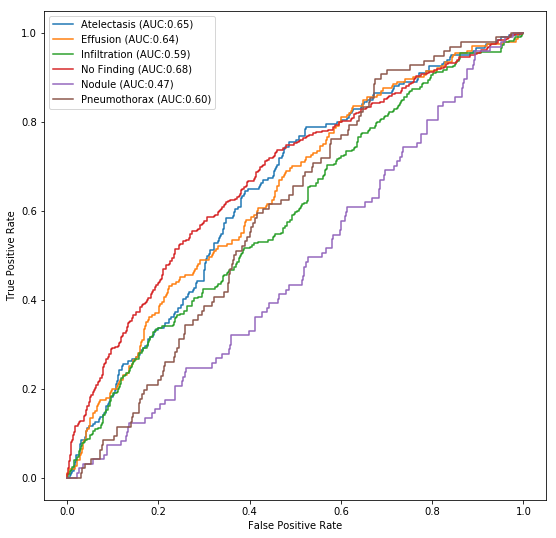

In [47]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [0]:
# Show images and associated predictions.

In [0]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_resnetimg_predictions.png')

In [0]:
multi_score = model_effnet.evaluate(test_X,test_Y)
print("Scores: \n" , (multi_score))
print("First label. Accuracy: %.2f%%" % (multi_score[0]*100))
print("Second label. Accuracy: %.2f%%" % (multi_score[1]*100))

In [48]:
resnet_history = model_effnet.fit_generator(
                                  train_gen,
  validation_data=(test_X, test_Y),
  epochs=10,
  steps_per_epoch= 10,
  callbacks = callbacks_list)


Epoch 1/10
10/10 [==============================] - 25s 2s/step - loss: 0.4483 - acc: 0.8120 - categorical_accuracy: 0.3812 - val_loss: 0.5708 - val_acc: 0.7676 - val_categorical_accuracy: 0.3574

Epoch 00001: val_loss did not improve from 0.52910
Epoch 2/10
10/10 [==============================] - 18s 2s/step - loss: 0.4750 - acc: 0.8047 - categorical_accuracy: 0.3750 - val_loss: 0.6087 - val_acc: 0.7617 - val_categorical_accuracy: 0.3486

Epoch 00002: val_loss did not improve from 0.52910
Epoch 3/10
10/10 [==============================] - 18s 2s/step - loss: 0.4659 - acc: 0.8047 - categorical_accuracy: 0.3750 - val_loss: 0.5644 - val_acc: 0.7694 - val_categorical_accuracy: 0.3506

Epoch 00003: val_loss did not improve from 0.52910
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 0.4439 - acc: 0.8109 - categorical_accuracy: 0.3750 - val_loss: 0.6042 - val_acc: 0.7606 - val_categorical_accuracy: 0.3496

Epoch 00004: val_loss did not improve from 0.52910
Epoch 5/

dict_keys(['val_loss', 'val_acc', 'val_categorical_accuracy', 'loss', 'acc', 'categorical_accuracy'])


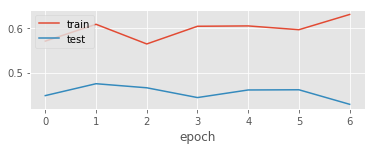

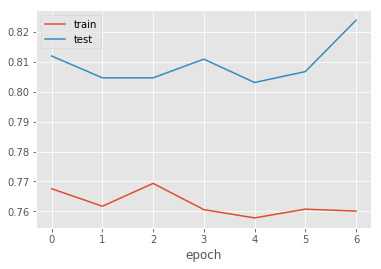

In [67]:
print(resnet_history.history.keys())
#str(history.history['loss',])
plt.subplot(211)  
#print(inception_history.history)
#print(callbacks_list)
plt.plot(resnet_history.history['val_loss'])  
plt.plot(resnet_history.history['loss'])  
#plt.plot(inception_history.history['binary_accuracy'])  
#plt.title('model accuracy')  
#plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
#plt.subplot(221)
plt.plot(resnet_history.history['val_acc'])  
plt.plot(resnet_history.history['acc'])  
#plt.plot(inception_history.history['binary_accuracy'])  
#plt.title('model accuracy')  
#plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

In [77]:
from sklearn import metrics
pred_class = np.round(pred_Y,1)
pred_class = np.round(pred_class)
classification_metrics = metrics.classification_report(test_Y, pred_class, target_names = all_labels)
print(classification_metrics)

              precision    recall  f1-score   support

 Atelectasis       0.00      0.00      0.00       199
    Effusion       0.00      0.00      0.00       200
Infiltration       0.45      0.04      0.07       285
  No Finding       0.44      0.76      0.56       354
      Nodule       0.00      0.00      0.00        97
Pneumothorax       0.00      0.00      0.00        96

   micro avg       0.44      0.23      0.30      1231
   macro avg       0.15      0.13      0.10      1231
weighted avg       0.23      0.23      0.17      1231
 samples avg       0.27      0.27      0.27      1231



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [69]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(test_Y, pred_class)

array([[[ 72, 753],
        [  7, 192]],

       [[279, 545],
        [ 29, 171]],

       [[ 29, 710],
        [  6, 279]],

       [[  0, 670],
        [  0, 354]],

       [[872,  55],
        [ 93,   4]],

       [[673, 255],
        [ 63,  33]]])

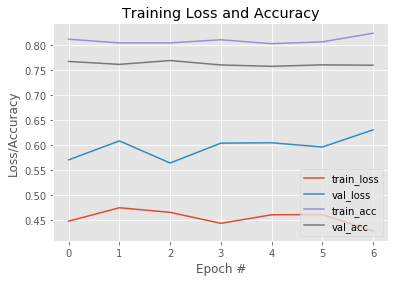

In [66]:
plt.style.use("ggplot")
plt.figure()
N = 7
plt.plot(np.arange(0, N), resnet_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), resnet_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), resnet_history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), resnet_history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
#plt.savefig(args["plot"])

In [60]:
pred_Y[10]

array([0.1374799 , 0.02308479, 0.07993641, 0.73968816, 0.00647339,
       0.00881082], dtype=float32)

In [0]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(args["plot"])